### does training on disease data do better than clinvar - hearing loss?

In [7]:
import pandas as pd
import numpy
from scipy.stats import entropy
import pydot, pydotplus, graphviz
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn import linear_model, metrics, tree, svm
from sklearn.neural_network import MLPClassifier
from sklearn.externals.six import StringIO
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import ExtraTreesClassifier
from IPython.display import HTML
%matplotlib inline

In [8]:
cols = ['mpc']
key_cols = ['chrom', 'pos', 'ref', 'alt']

right_benign = "#32CD32"
right_path = "#2ecc71"
wrong_path = "#e74c3c"
wrong_benign = "#ffcccb"
flatui = [right_benign, right_path, wrong_benign, wrong_path]

def eval_pred(row, col):
    if row[col] == row['y']:
        if row['y'] == 1:
            return 'CorrectPath'
        return 'CorrectBenign'
    if row['y'] == 1:
        return 'WrongPath'
    return 'WrongBenign'

In [9]:
# load clinvar
dat_file = '../data/interim/clinvar/clinvar.limit3.dat'
clinvar_df = pd.read_csv(dat_file, sep='\t').rename(columns={'clin_class':'y'})

In [10]:
# other disease df: missense
dat_file = '../data/interim/other/other.eff.dbnsfp.anno.hHack.dat.limit.xls'
disease_df_pre = pd.read_csv(dat_file, sep='\t')
disease_df_pre.loc[:, 'y'] = disease_df_pre.apply(lambda row: 1 if row['class']=='P' else 0, axis=1)
#train_keys = {':'.join([str(x) for x in v]):True for v in train_df[key_cols].values}
#tree_clf = tree.DecisionTreeClassifier(max_depth=1)
#X, y = train_df[cols], train_df['y']
#tree_clf.fit(X, y)

/opt/conda/lib/python3.4/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

,PredictionStatusMPC,size
0,CorrectBenign,622
1,WrongPath,106


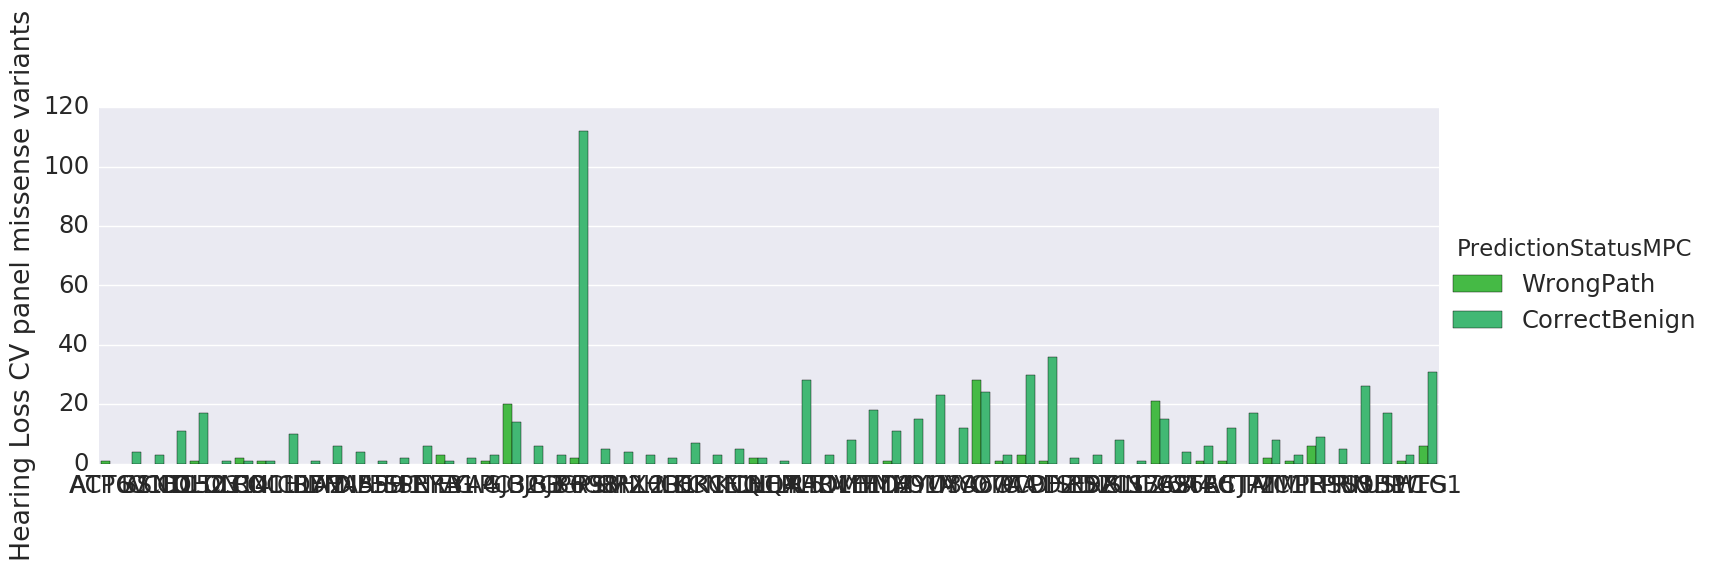

In [11]:
# one gene at a time
disease = 'Hearing Loss'
disease_df = disease_df_pre[disease_df_pre.Disease==disease]
acc_df_ls = []
genes = set(disease_df['gene'])

tree_clf_clinvar = tree.DecisionTreeClassifier(max_depth=1)
X, y = clinvar_df[cols], clinvar_df['y']
tree_clf_clinvar.fit(X, y)
    
for test_gene in genes:
    sub_train_df = disease_df[disease_df.gene != test_gene]
    tree_clf_sub = tree.DecisionTreeClassifier(max_depth=1)
    X, y = sub_train_df[cols], sub_train_df['y']
    tree_clf_sub.fit(X, y)
    
    test_df = disease_df[disease_df.gene == test_gene]
    X_test = test_df[cols]
    preds = tree_clf_sub.predict(X_test)
    test_df['mpc_pred'] = preds
    test_df.loc[:, 'PredictionStatusMPC'] = test_df.apply(lambda row: eval_pred(row, 'mpc_pred'), axis=1)
    
    preds = tree_clf_clinvar.predict(X_test)
    test_df['mpc_pred_clinvar'] = preds
    test_df.loc[:, 'PredictionStatusMPC_clinvar'] = test_df.apply(lambda row: eval_pred(row, 'mpc_pred_clinvar'), axis=1)
    
    acc_df_ls.append(test_df)

test_df = pd.concat(acc_df_ls)
g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC']]
        .groupby(['gene', 'PredictionStatusMPC'])
        .size().reset_index().rename(columns={0:'size'}))
dd = g_df.groupby('gene').sum().reset_index()

sns.set(font_scale=1.75)
ss = sns.factorplot(x='gene', hue='PredictionStatusMPC', y='size', data=g_df,
                    kind='bar', palette=sns.color_palette(flatui), size=5, aspect=3)
ss.set_ylabels('%s CV panel missense variants' % (disease,))
ss.set_xlabels('')
ss.set_titles('MPC performance')
ss.savefig("../docs/plots/%s_cv_mpc_eval.png" % (disease,))

g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC']]
        .groupby(['PredictionStatusMPC'])
        .size().reset_index().rename(columns={0:'size'}))
g_df.head()

,PredictionStatusMPC_clinvar,size
0,CorrectBenign,572
1,CorrectPath,13
2,WrongBenign,50
3,WrongPath,93


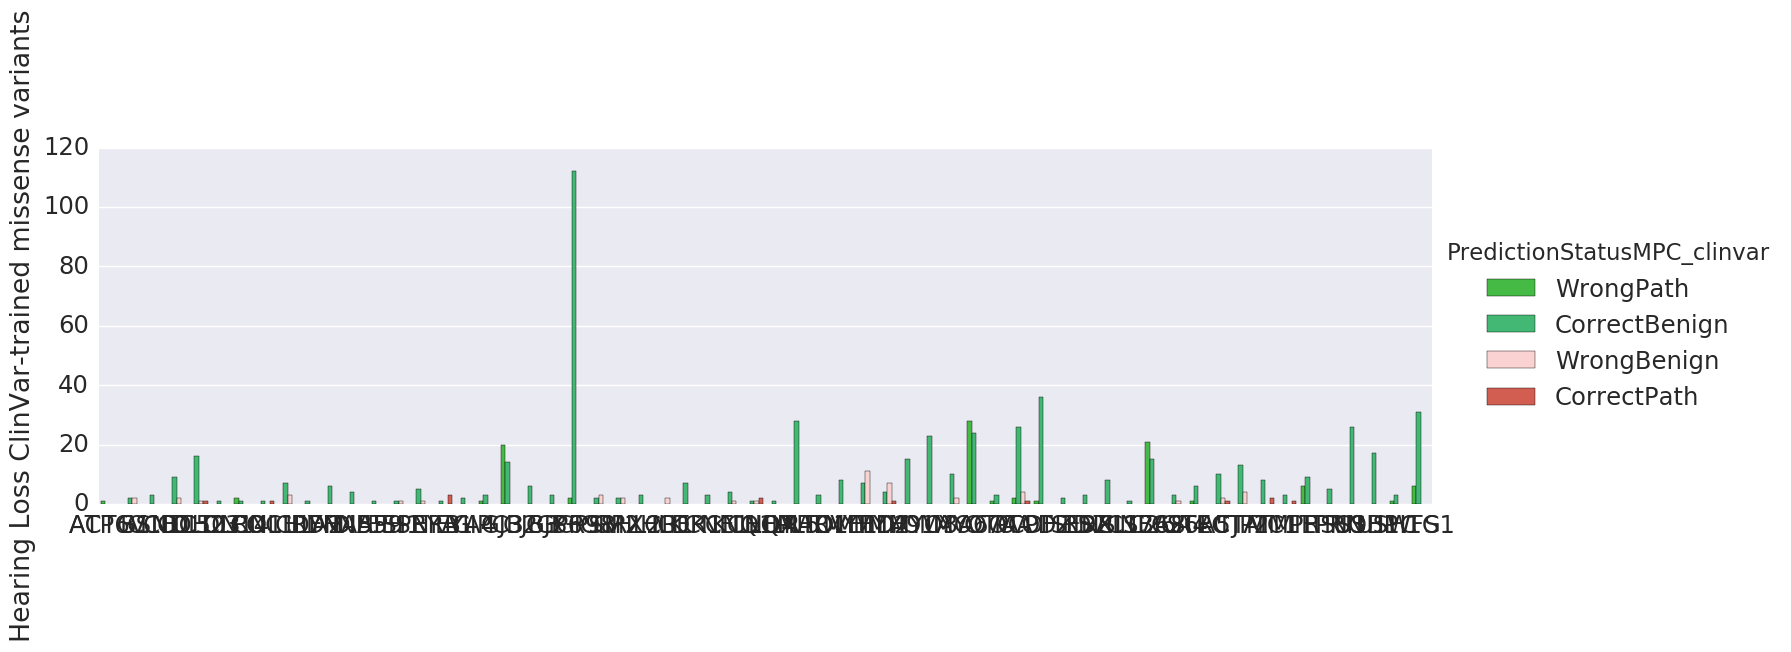

In [12]:
g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC_clinvar']]
        .groupby(['gene', 'PredictionStatusMPC_clinvar'])
        .size().reset_index().rename(columns={0:'size'}))
dd = g_df.groupby('gene').sum().reset_index()

sns.set(font_scale=1.75)
ss = sns.factorplot(x='gene', hue='PredictionStatusMPC_clinvar', y='size', data=g_df,
                    kind='bar', palette=sns.color_palette(flatui), size=5, aspect=3)
ss.set_ylabels('%s ClinVar-trained missense variants' % (disease,))
ss.set_xlabels('')
ss.set_titles('MPC performance')
#ss.savefig("../docs/plots/%s_cv_mpc_eval.png" % (disease,))

g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC_clinvar']]
        .groupby(['PredictionStatusMPC_clinvar'])
        .size().reset_index().rename(columns={0:'size'}))
g_df.head()